In [12]:
import pandas as pd 
import geopandas as gpd
income_data = pd.read_csv("/home/ryanwonhail/project-2-group-real-estate-industry-project-34/data/raw/au-govt-abs-abs-data-by-region-income-asgs-sa2-2011-2019-sa2-2016(vic, correct).csv")
sf = gpd.read_file("/home/ryanwonhail/project-2-group-real-estate-industry-project-34/data/SA2 Zones/SA2_2021_AUST_GDA2020.shp")


In [13]:
income_data.count()
income_data.shape

(1771, 71)

In [14]:

null_values = income_data.isnull().sum().nlargest(10)
print(null_values)
max_null_values = income_data.isnull().sum().max()
print(max_null_values)
missing_percentage = income_data.isnull().mean() * 100


high_missing_cols = missing_percentage[missing_percentage > 50]  
print(high_missing_cols)


exprmntl_hshld_wlth_estmts_mdlld_prvte_dwllngs_mn_nt_wrth          1479
ttl_prsnl_incme_wkly_prsns_agd_15_yrs_cnss_ngtve_pc                1479
ttl_prsnl_incme_wkly_prsns_agd_15_yrs_cnss_ernng_3000_pr_wk_pc     1478
ttl_prsnl_incme_wkly_prsns_agd_15_yrs_cnss_ernng_1_499_pr_wk_pc    1477
tl_prsnl_incme_wkly_prsn_agd_15_yrs_cns_erng_500_999_pr_wk_pc      1477
tl_prsnl_incme_wkly_prsn_agd_15_yrs_cns_erng_1000_1999_pr_wk_pc    1477
tl_prsnl_incme_wkly_prsn_agd_15_yrs_cns_erng_2000_2999_pr_wk_pc    1477
ttl_prsnl_incme_wkly_prsns_agd_15_yrs_cnss_ernng_nl_pc             1477
tl_prsnl_incme_wkly_prsn_agd_15_yrs_cns_indqtly_dscrb_std_pc       1477
slctd_gvrnmnt_pnsns_allwncs_30_jne_prntng_pymnt_prtnrd_nm          1227
dtype: int64
1479
slctd_gvrnmnt_pnsns_allwncs_30_jne_crr_allwnce_nm                  67.024280
slctd_gvrnmnt_pnsns_allwncs_30_jne_prntng_pymnt_prtnrd_nm          69.282891
slctd_gvrnmnt_pnsns_allwncs_30_jne_cmmnwlth_rnt_assstnce_nm        66.911350
exprmntl_hshld_wlth_estmts_mdll

In [15]:
# Check for columns that have no values at all (i.e., 100% missing values)
empty_columns = income_data.columns[income_data.isnull().all()]
empty_columns


Index([], dtype='object')

In [16]:
# Select only numeric columns from income_data
numeric_columns = income_data.select_dtypes(include=['float64', 'int64']).columns

# checks through columns with missing values and impute them using Random Forest on numeric columns only.
from sklearn.ensemble import RandomForestRegressor

# Function to impute missing values using Random Forest
def random_forest_impute(data, target_column, feature_columns):
    # Separate the rows with missing values in the target column
    not_null_data = data[data[target_column].notnull()]
    null_data = data[data[target_column].isnull()]
    
    # If there are no missing values, return the data as is
    if null_data.empty:
        return data
    
   
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    
    #this is for training with no missing values 
    X_train = not_null_data[feature_columns]
    y_train = not_null_data[target_column]
    rf.fit(X_train, y_train)
    
    # Predict on rows with missing values
    X_null = null_data[feature_columns]
    predicted_values = rf.predict(X_null)
    
    # Fill the missing values with the predicted values on those column
    data.loc[data[target_column].isnull(), target_column] = predicted_values
    
    return data

# Get columns with missing values
columns_with_missing = income_data.columns[income_data.isnull().any()]

income_data_imputed = income_data.copy()

# Iterate over the columns with missing values and impute them
for column in columns_with_missing:
    # Use numeric columns only for features, excluding the target column itself
    features = numeric_columns.difference([column])
    # Impute missing values in income_data_imputed
    income_data_imputed = random_forest_impute(income_data_imputed, column, features)

#to check our result 
missing_values_after_imputation = income_data_imputed.isnull().sum()

# to double check 
missing_values_after_imputation[missing_values_after_imputation > 0]


Series([], dtype: int64)

In [17]:
income_data_imputed.shape


(1771, 71)

In [18]:
sf = sf.drop(index=2472)

In [21]:
# Rename the column in 'sf' DataFrame
sf.rename(columns={'SA2_CODE21': 'Statistical Areas Level 2 2021 code'}, inplace=True)

# Convert 'Statistical Areas Level 2 2021 code' in both DataFrames to strings before merging
sf['Statistical Areas Level 2 2021 code'] = sf['Statistical Areas Level 2 2021 code'].astype(str)
income_data_imputed['Statistical Areas Level 2 2021 code'] = income_data_imputed['Statistical Areas Level 2 2021 code'].astype(str)

# Now perform the merge
merged_df = sf.merge(income_data_imputed, how='inner', on='Statistical Areas Level 2 2021 code')

# Check the result
print(merged_df.head())

# Filter for Victoria
victoria_income_2011_2019 = merged_df[merged_df['STE_NAME21'] == 'Victoria']
print(victoria_income_2011_2019.shape)


  Statistical Areas Level 2 2021 code      SA2_NAME21 CHG_FLAG21  CHG_LBL21  \
0                           109011173  Albury - North          0  No change   
1                           109011173  Albury - North          0  No change   
2                           109011173  Albury - North          0  No change   
3                           109011173  Albury - North          0  No change   
4                           109011173  Albury - North          0  No change   

  SA3_CODE21 SA3_NAME21 SA4_CODE21 SA4_NAME21 GCC_CODE21   GCC_NAME21  ...  \
0      10901     Albury        109     Murray      1RNSW  Rest of NSW  ...   
1      10901     Albury        109     Murray      1RNSW  Rest of NSW  ...   
2      10901     Albury        109     Murray      1RNSW  Rest of NSW  ...   
3      10901     Albury        109     Murray      1RNSW  Rest of NSW  ...   
4      10901     Albury        109     Murray      1RNSW  Rest of NSW  ...   

  exprmntl_hshld_wlth_estmts_mdlld_prvte_dwllngs_mn_nt_w

In [22]:

columns_to_drop = ['SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21', 'SA3_NAME21', 
                   'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21', 'STE_CODE21', 
                   'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 
                   'geometry']


victoria_income_cleaned = victoria_income_2011_2019.drop(columns=columns_to_drop)

victoria_income_cleaned.columns


Index(['Statistical Areas Level 2 2021 code', 'FID', 'sa2_name_2016', 'yr',
       'estmts_prsnl_incme_yr_endd_30_jne_emplye_ernrs_nm',
       'estmts_prsnl_incme_yr_endd_30_jne_emplye_ernrs_mdn_age_yrs',
       'estimates_personal_income_year_ended_30_june_total_employee_m',
       'estimates_personal_income_year_ended_30_june_median_employee',
       'estimates_personal_income_year_ended_30_june_mean_employee',
       'estmts_prsnl_incme_yr_endd_30_jne_emplye_mn_srce_of_pc',
       'estmts_prsnl_incme_yr_endd_30_jne_unncrprtd_bsnss_ernrs_nm',
       'estm_prsnl_incme_yr_end_30_jne_uncrptd_bsn_erns_mdn_age_yrs',
       'estmts_prsnl_incme_yr_endd_30_jne_ttl_unncrprtd_bsnss_m',
       'estmts_prsnl_incme_yr_endd_30_jne_mdn_unncrprtd_bsnss',
       'estmts_prsnl_incme_yr_endd_30_jne_mn_unncrprtd_bsnss',
       'estmts_prsnl_incme_yr_endd_30_jne_unncrprtd_bsnss_mn_srce_of_pc',
       'estmts_prsnl_incme_yr_endd_30_jne_invstmnt_ernrs_nm',
       'estmts_prsnl_incme_yr_endd_30_jne_invstmnt

In [26]:
victoria_income_cleaned.to_csv('median_income_prediction 2011-2019 before feature selection .csv', index=False)

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
target_column = 'estm_prsnl_incme_yr_end_30_jne_mdn_tl_excl_gvrnmt_pns_alwncs'
numerical_df = victoria_income_cleaned.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numerical columns
correlation_matrix = numerical_df.corr()
correlation_matrix
correlation_with_target = correlation_matrix[target_column].sort_values(ascending = False)
# Display correlations with the target column
correlation_with_target.head(15)



estm_prsnl_incme_yr_end_30_jne_mdn_tl_excl_gvrnmt_pns_alwncs       1.000000
estimates_personal_income_year_ended_30_june_mean_employee         0.911193
estm_prsnl_incme_yr_end_30_jne_tl_excl_gvrnmt_pns_alwncs_hgst_q    0.910730
tl_prsnl_incme_wkly_prsn_agd_15_yrs_cns_erng_2000_2999_pr_wk_pc    0.892991
estm_prsnl_incme_yr_end_30_jne_mn_tl_excl_gvrnmt_pns_alwncs        0.884822
ttl_prsnl_incme_wkly_prsns_agd_15_yrs_cnss_ernng_3000_pr_wk_pc     0.851269
estimates_personal_income_year_ended_30_june_median_employee       0.827176
tl_prsnl_incme_wkly_prsn_agd_15_yrs_cns_erng_1000_1999_pr_wk_pc    0.766470
equivalised_total_household_income_census_median_weekly            0.693357
estimates_personal_income_year_ended_30_june_mean_investment       0.625605
exprmntl_hshld_wlth_estmts_mdlld_prvte_dwllngs_mn_nt_wrth          0.527417
estmts_prsnl_incme_yr_endd_30_jne_mn_unncrprtd_bsnss               0.500245
estmts_prsnl_incme_yr_endd_30_jne_mn_sprnntn_annty                 0.499733
estm_prsnl_i

In [25]:
from sklearn.preprocessing import StandardScaler
top_features = [
    'estimates_personal_income_year_ended_30_june_mean_employee',
    'estm_prsnl_incme_yr_end_30_jne_tl_excl_gvrnmt_pns_alwncs_hgst_q',
    'tl_prsnl_incme_wkly_prsn_agd_15_yrs_cns_erng_2000_2999_pr_wk_pc',
    'estm_prsnl_incme_yr_end_30_jne_mn_tl_excl_gvrnmt_pns_alwncs',
    'ttl_prsnl_incme_wkly_prsns_agd_15_yrs_cnss_ernng_3000_pr_wk_pc',
    'estimates_personal_income_year_ended_30_june_median_employee',
    'tl_prsnl_incme_wkly_prsn_agd_15_yrs_cns_erng_1000_1999_pr_wk_pc',
    'equivalised_total_household_income_census_median_weekly',
    'estimates_personal_income_year_ended_30_june_mean_investment',
    'exprmntl_hshld_wlth_estmts_mdlld_prvte_dwllngs_mn_nt_wrth',
    'estmts_prsnl_incme_yr_endd_30_jne_mn_unncrprtd_bsnss',
    'estmts_prsnl_incme_yr_endd_30_jne_mn_sprnntn_annty',
    'estm_prsnl_incme_yr_end_30_jne_tl_excl_gvrnmt_pns_alwncs_m',
    'estm_prsnl_incme_yr_end_30_jne_tl_excl_gvrnmt_pns_alwncs_p805_r',
    'yr'
]

scaler = StandardScaler()
y = victoria_income_cleaned['estm_prsnl_incme_yr_end_30_jne_mdn_tl_excl_gvrnmt_pns_alwncs']
# top_features is a list of feature names from your correlation analysis
X = victoria_income_cleaned[top_features]
year_column = victoria_income_cleaned['yr']
X_scaled = scaler.fit_transform(X)
# Split the data into 2011-2017 for training and 2018 for testing
X_train = X[year_column < 2018]
y_train = y[year_column < 2018]

X_test = X[year_column == 2018]
y_test = y[year_column == 2018]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()

#gets the top 4 features 
rfe = RFE(model, n_features_to_select=4)
rfe = rfe.fit(X_scaled, y)

# Get the ranking of the features
print("Feature ranking:", rfe.ranking_)

selected_features = [feature for feature, rank in zip(top_features, rfe.ranking_) if rank == 1]
print("Selected Features:", selected_features)

# Get the selected feature indices
selected_features_idx = rfe.get_support(indices=True)

# Select the columns from X_train and X_test corresponding to the selected features
X_train_selected = X_train_scaled[:, selected_features_idx]
X_test_selected = X_test_scaled[:, selected_features_idx]



Feature ranking: [ 3  1  6  1  2  1  9  8  4  5 12 11 10  1  7]
Selected Features: ['estm_prsnl_incme_yr_end_30_jne_tl_excl_gvrnmt_pns_alwncs_hgst_q', 'estm_prsnl_incme_yr_end_30_jne_mn_tl_excl_gvrnmt_pns_alwncs', 'estimates_personal_income_year_ended_30_june_median_employee', 'estm_prsnl_incme_yr_end_30_jne_tl_excl_gvrnmt_pns_alwncs_p805_r']


In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor
model_final = LinearRegression()

# Fit the model on the selected features of the training data
model_final.fit(X_train_selected, y_train)

# Predict on the selected features of the test data (2018)
y_pred = model_final.predict(X_test_selected)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on 2018 data: {mse}')

# Optional: Print the predicted vs actual values
print("Predicted values:", y_pred[:5])
print("Actual values:", y_test[:5])

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error on 2018 data: 45769.67683835923
Predicted values: [53069.94807578 53100.68041758 53442.46196499 53035.12059024
 53360.29309033]
Actual values: 23    53008.69
29    52792.62
35    53648.01
41    52986.05
47    53458.46
Name: estm_prsnl_incme_yr_end_30_jne_mdn_tl_excl_gvrnmt_pns_alwncs, dtype: float64
R² Score: 0.6276195121763144


In [28]:
target_variance = y_test.var()
print("Variance of the target variable:", target_variance)


Variance of the target variable: 123393.05433450387


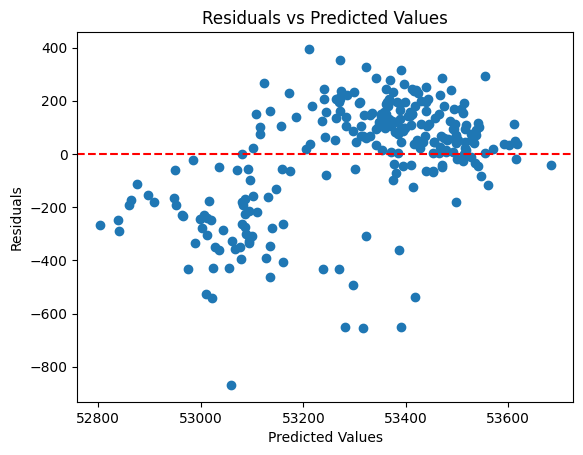

In [55]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [37]:
# Fit the model on the training data (all available data) before making predictions
X_train_selected = X_scaled[:, selected_features_idx]
model.fit(X_train_selected, y)

# Now proceed with forecasting for 2011, 2014, 2015, 2016, and 2017
years_to_predict = [2011, 2014, 2015, 2016, 2017]
forecast_results = {}

for year in years_to_predict:
    # Filter the data for each year
    X_year = victoria_income_cleaned[victoria_income_cleaned['yr'] == year][top_features]
    
    # Scale and select the relevant features
    X_year_scaled = scaler.transform(X_year)
    X_year_selected = X_year_scaled[:, selected_features_idx]
    
    # Make predictions for the selected years
    y_pred_year = model.predict(X_year_selected)
    
    # Store the predictions for each year in a new column
    victoria_income_cleaned.loc[victoria_income_cleaned['yr'] == year, f'{year}_Forecast'] = y_pred_year

# Format the forecast data
final_forecast_columns = ['Statistical Areas Level 2 2021 code', 'sa2_name_2016']

# Create a DataFrame with the relevant columns (only unique suburbs and their codes)
formatted_forecast_df = victoria_income_cleaned[['Statistical Areas Level 2 2021 code', 'sa2_name_2016']].drop_duplicates()

# Merge forecasted columns for each year (ensuring each suburb appears only once)
for year in [2011, 2014, 2015, 2016, 2017]:
    formatted_forecast_df = formatted_forecast_df.merge(
        victoria_income_cleaned[['Statistical Areas Level 2 2021 code', f'{year}_Forecast']].drop_duplicates(),
        on='Statistical Areas Level 2 2021 code',
        how='left'
    )

# Now apply the unique function using groupby to ensure each suburb appears only once, and take the first non-null value for each year
unique_forecast_df = formatted_forecast_df.groupby(['Statistical Areas Level 2 2021 code', 'sa2_name_2016']).agg({
    '2011_Forecast': 'first',
    '2014_Forecast': 'first',
    '2015_Forecast': 'first',
    '2016_Forecast': 'first',
    '2017_Forecast': 'first'
}).reset_index()


In [38]:
# Add forecasts for 2012 and 2013 based on a 2% increase from 2011
unique_forecast_df['2012_Forecast'] = unique_forecast_df['2011_Forecast'] * 1.02
unique_forecast_df['2013_Forecast'] = unique_forecast_df['2012_Forecast'] * 1.02
unique_forecast_df['2018_Forecast'] = unique_forecast_df['2017_Forecast'] * 1.02
unique_forecast_df['2019 Forecast'] = unique_forecast_df['2018_Forecast'] * 1.02
unique_forecast_df['2020 Forecast'] = unique_forecast_df['2019_Forecast'] * 1.02
unique_forecast_df['2021 Forecast'] = unique_forecast_df['2020_Forecast'] * 1.02
unique_forecast_df['2022 Forecast'] = unique_forecast_df['2021_Forecast'] * 1.02
unique_forecast_df['2023 Forecast'] = unique_forecast_df['2022_Forecast'] * 1.02
unique_forecast_df['2024 Forecast'] = unique_forecast_df['2023_Forecast'] * 1.02
unique_forecast_df['2025 Forecast'] = unique_forecast_df['2024_Forecast'] * 1.02
unique_forecast_df['2026 Forecast'] = unique_forecast_df['2025_Forecast'] * 1.02
unique_forecast_df['2027 Forecast'] = unique_forecast_df['2026_Forecast'] * 1.02

# Rename columns to match the desired format
unique_forecast_df.columns = ['Statistical Areas Level 2 2021 code', 'Suburb', 
                              '2011_Forecast', '2012_Forecast', '2013_Forecast', 
                              '2014_Forecast', '2015_Forecast', '2016_Forecast', '2017_Forecast','2018_Forecast',
                              '2019_Forecast' ,'2020_Forecast','2021_Forecast','2022_Forecast', '2023_Forecast',
                              '2024_Forecast','2025_Forecast','2026_Forecast','2027_Forecast']

# Display the first few rows of the unique forecast data with the new columns
unique_forecast_df.head()

,Statistical Areas Level 2 2021 code,Suburb,2011_Forecast,2012_Forecast,2013_Forecast,2014_Forecast,2015_Forecast,2016_Forecast,2017_Forecast
0,201011001,Alfredton,53432.300711,47374.846028,48517.071460,49263.565645,50170.087016,54500.946725,55590.965660
1,201011002,Ballarat,53427.649686,48983.463985,49079.438428,51245.827182,50976.856327,54496.202680,55586.126734
2,201011005,Buninyong,53434.168203,48096.026338,48160.656680,48454.660943,49869.710290,54502.851567,55592.908599
3,201011006,Delacombe,53433.458267,42962.681074,44104.552914,44806.359633,45933.596608,54502.127432,55592.169981
4,201011007,Smythes Creek,53427.649686,45307.819756,45709.905976,46621.391935,48000.556821,54496.202680,55586.126734


In [ ]:
forecast_2020_2023 = pd.read_csv("")

In [ ]:
# Merge the 2011-2023 data
forecast_2011_2023 = unique_forecast_df.merge(forecast_2020_2023, how='inner', on='Statistical Areas Level 2 2021 code')

In [40]:
unique_forecast_df.to_csv('median_income_prediction 2011-2019-final.csv', index=False)

In [20]:
# Create a DataFrame to display the results for 2018 with Code, Suburb, and Predicted 2018 Forecast
test_data_2018 = victoria_income_cleaned[victoria_income_cleaned['yr'] == 2018].copy()
test_data_2018['2018_Forecast'] = y_pred

# Select the columns 'Statistical Areas Level 2 2021 code', 'sa2_name_2016', and the new forecasted column
final_2018_forecast = test_data_2018[['Statistical Areas Level 2 2021 code', 'sa2_name_2016', '2018_Forecast']]

# Rename columns to match the desired format ('Code', 'Suburb', '2018_Forecast')
final_2018_forecast.columns = ['Code', 'Suburb', '2018_Forecast']

# Display the final output similar to the format shown in your image
print(final_2018_forecast.head())

         Code         Suburb  2018_Forecast
23  201011001      Alfredton   53069.948076
29  201011002       Ballarat   53100.680418
35  201011005      Buninyong   53442.461965
41  201011006      Delacombe   53035.120590
47  201011007  Smythes Creek   53360.293090


In [24]:
#final_forecast_df.to_csv('median_income_prediction 2011-2019.csv', index=False)